# Support Code

In [1]:
# You are expected to use this support code if you are writing code in Python.
# You may want to write:
# from ct_support_code import *
# at the top of your answers

# You will need numpy and scipy:
import numpy as np
from scipy.optimize import minimize

def params_unwrap(param_vec, shapes, sizes):
    """Helper routine for minimize_list"""
    args = []
    pos = 0
    for i in range(len(shapes)):
        sz = sizes[i]
        args.append(param_vec[pos:pos+sz].reshape(shapes[i]))
        pos += sz
    return args

def params_wrap(param_list):
    """Helper routine for minimize_list"""
    param_list = [np.array(x) for x in param_list]
    shapes = [x.shape for x in param_list]
    sizes = [x.size for x in param_list]
    param_vec = np.zeros(sum(sizes))
    pos = 0
    for param in param_list:
        sz = param.size
        param_vec[pos:pos+sz] = param.ravel()
        pos += sz
    unwrap = lambda pvec: params_unwrap(pvec, shapes, sizes)
    return param_vec, unwrap

def minimize_list(cost, init_list, args):
    """Optimize a list of arrays (wrapper of scipy.optimize.minimize)

    The input function "cost" should take a list of parameters,
    followed by any extra arguments:
        cost(init_list, *args)
    should return the cost of the initial condition, and a list in the same
    format as init_list giving gradients of the cost wrt the parameters.

    The options to the optimizer have been hard-coded. You may wish
    to change disp to True to get more diagnostics. You may want to
    decrease maxiter while debugging. Although please report all results
    in Q2-5 using maxiter=500.

    The Matlab code comes with a different optimizer, so won't give the same
    results.
    """
    opt = {'maxiter': 500, 'disp': False}
    init, unwrap = params_wrap(init_list)
    def wrap_cost(vec, *args):
        E, params_bar = cost(unwrap(vec), *args)
        vec_bar, _ = params_wrap(params_bar)
        return E, vec_bar
    res = minimize(wrap_cost, init, args, 'L-BFGS-B', jac=True, options=opt)
    return unwrap(res.x)


def linreg_cost(params, X, yy, alpha):
    """Regularized least squares cost function and gradients

    Can be optimized with minimize_list -- see fit_linreg_gradopt for a
    demonstration.

    Inputs:
    params: tuple (ww, bb): weights ww (D,), bias bb scalar
         X: N,D design matrix of input features
        yy: N,  real-valued targets
     alpha: regularization constant

    Outputs: (E, [ww_bar, bb_bar]), cost and gradients
    """
    # Unpack parameters from list
    ww, bb = params

    # forward computation of error
    ff = np.dot(X, ww) + bb
    res = ff - yy
    E = np.dot(res, res) + alpha*np.dot(ww, ww)

    # reverse computation of gradients
    ff_bar = 2*res
    bb_bar = np.sum(ff_bar)
    ww_bar = np.dot(X.T, ff_bar) + 2*alpha*ww

    return E, [ww_bar, bb_bar]

def fit_linreg_gradopt(X, yy, alpha):
    """
    fit a regularized linear regression model with gradient opt

         ww, bb = fit_linreg_gradopt(X, yy, alpha)

     Find weights and bias by using a gradient-based optimizer
     (minimize_list) to improve the regularized least squares cost:

       np.sum(((np.dot(X,ww) + bb) - yy)**2) + alpha*np.dot(ww,ww)

     Inputs:
             X N,D design matrix of input features
            yy N,  real-valued targets
         alpha     scalar regularization constant

     Outputs:
            ww D,  fitted weights
            bb     scalar fitted bias
    """
    D = X.shape[1]
    args = (X, yy, alpha)
    init = (np.zeros(D), np.array(0))
    ww, bb = minimize_list(linreg_cost, init, args)
    return ww, bb


def pca_zm_proj(X, K=None):
    """return PCA projection matrix for zero mean data

    Inputs:
        X N,D design matrix of input features -- must be zero mean
        K     how many columns to return in projection matrix

    Outputs:
        V D,K matrix to apply to X or other matrices shifted in same way.
    """
    if np.max(np.abs(np.mean(X,0))) > 1e-9:
        raise ValueError('Data is not zero mean.')
    if K is None:
        K = X.shape[1]
    E, V = np.linalg.eig(np.dot(X.T, X))
    idx = np.argsort(E)[::-1]
    V = V[:, idx[:K]] # D,K
    return V


def logreg_cost(params, X, yy, alpha):
    """Regularized logistic regression cost function and gradients

    Can be optimized with minimize_list -- see fit_linreg_gradopt for a
    demonstration of fitting a similar function.

    Inputs:
    params: tuple (ww, bb): weights ww (D,), bias bb scalar
         X: N,D design matrix of input features
        yy: N,  real-valued targets
     alpha: regularization constant

    Outputs: (E, [ww_bar, bb_bar]), cost and gradients
    """
    # Unpack parameters from list
    ww, bb = params

    # Force targets to be +/- 1
    yy = 2*(yy==1) - 1

    # forward computation of error
    aa = yy*(np.dot(X, ww) + bb)
    sigma = 1/(1 + np.exp(-aa))
    E = -np.sum(np.log(sigma)) + alpha*np.dot(ww, ww)

    # reverse computation of gradients
    aa_bar = sigma - 1
    bb_bar = np.dot(aa_bar, yy)
    ww_bar = np.dot(X.T, yy*aa_bar) + 2*alpha*ww

    return E, (ww_bar, bb_bar)


def nn_cost(params, X, yy=None, alpha=None):
    """NN_COST simple neural network cost function and gradients, or predictions

           E, params_bar = nn_cost([ww, bb, V, bk], X, yy, alpha)
                    pred = nn_cost([ww, bb, V, bk], X)

     Cost function E can be minimized with minimize_list

     Inputs:
             params (ww, bb, V, bk), where:
                    --------------------------------
                        ww K,  hidden-output weights
                        bb     scalar output bias
                         V K,D hidden-input weights
                        bk K,  hidden biases
                    --------------------------------
                  X N,D input design matrix
                 yy N,  regression targets
              alpha     scalar regularization for weights

     Outputs:
                     E  sum of squares error
            params_bar  gradients wrt params, same format as params
     OR
               pred N,  predictions if only params and X are given as inputs
    """
    # Unpack parameters from list
    ww, bb, V, bk = params

    # Forwards computation of cost
    A = np.dot(X, V.T) + bk[None,:] # N,K
    P = 1 / (1 + np.exp(-A)) # N,K
    F = np.dot(P, ww) + bb # N,
    if yy is None:
        # user wants prediction rather than training signal:
        return F
    res = F - yy # N,
    E = np.dot(res, res) + alpha*(np.sum(V*V) + np.dot(ww,ww)) # 1x1

    # Reverse computation of gradients
    F_bar = 2*res # N,
    ww_bar = np.dot(P.T, F_bar) + 2*alpha*ww # K,
    bb_bar = np.sum(F_bar) # scalar
    P_bar = np.dot(F_bar[:,None], ww[None,:]) # N,
    A_bar = P_bar * P * (1 - P) # N,
    V_bar = np.dot(A_bar.T, X) + 2*alpha*V # K,
    bk_bar = np.sum(A_bar, 0)

    return E, (ww_bar, bb_bar, V_bar, bk_bar)

# Load Data

In [2]:
%matplotlib inline
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

mat_contents = scipy.io.loadmat("ct_data.mat", squeeze_me=True)
X_train = mat_contents['X_train']
X_val = mat_contents['X_val']
X_test = mat_contents['X_test']
y_train = mat_contents['y_train']
y_val = mat_contents['y_val']
y_test = mat_contents['y_test']

# Q1a

In [3]:
assert np.isclose(y_train.mean(),0)
assert not np.isclose(y_val.mean(),0)
y_val_stderr = y_val.std()/((y_val.shape[0])**0.5)
y_train_stderr = y_train.std()/((y_train.shape[0])**0.5)
print("y_val   mean = %f, std = %f, stderr = %f" % (y_val.mean(),   y_val.std(),   y_val_stderr))
print("y_train mean = %f, std = %f, stderr = %f" % (y_train.mean(), y_train.std(), y_train_stderr))

y_val   mean = -0.216009, std = 0.981421, stderr = 0.012903
y_train mean = -0.000000, std = 0.999988, stderr = 0.004953


The mean of y_train is zero within numberical rounding errors. The mean of y_val is not zero. 
The mean of y_val is approximately $-2.16\times10^{-1}$. Its standard error is $1.29\times10^{-2}$.
For comparison, the mean of y_train is close $0$. Its standard error is $4.95\times10^{-3}$.

This is a misuse of stardard error of the mean (SEM) caused by confusion between SEM and standard deviation of the obervations. Standard deivation of observations, as a descriptive statistics, describes the property of observed data. As the sample size grows, standard deviation of sampled observations is approximate to the standard deviation of population. Standard deviation over y_train is approximately equal to standard deiation over y_val.

SEM is estimated by standard deviation of the sampling distribution. SEM measures the dispersion of sample means around population mean. SEM only measures the dispersion for a particular sample size. As sample size increases, SEM tends to zero. SEM of y_train is smaller than SEM of y_val because y_train has more samples than y_val. Therefore, SEM should not be used to estimate the average locations in future data. 

# Q1b

In [4]:
# remove constant features
temp = np.all(X_train==X_train[0,:], axis = 0)
constant_feature_indices = np.where(temp==True)
print("constant features' indices are", constant_feature_indices)
X_train = np.delete(X_train, constant_feature_indices, axis=1)
X_val = np.delete(X_val, constant_feature_indices, axis=1)
X_test = np.delete(X_test, constant_feature_indices, axis=1)

constant features' indices are (array([ 59,  69, 179, 189, 351]),)


In [5]:
def remove_duplicates(dataset):
    arr = np.empty(dataset.shape[1], dtype=bool)
    for idx1 in range(dataset.shape[1]):
        for idx2 in range(idx1+1,dataset.shape[1]):
            arr[idx2] = np.all(dataset[:,idx1]==dataset[:,idx2])
            arr[idx1] = np.all(dataset[:,idx1]==dataset[:,idx2])
    return arr

In [6]:
# remove duplicate features
col_num = X_train.shape[1]
_,idx = np.unique(X_train,axis=1, return_index=True)
X_train = X_train[:,np.sort(idx)]
X_val = X_val[:,np.sort(idx)]
X_test = X_test[:,np.sort(idx)]

counter = 0
duplicate_feature_indices = np.zeros((1,col_num-X_train.shape[1]),dtype=int)
for value in range(col_num):
    if value not in np.sort(idx):
        duplicate_feature_indices[0,counter]=value
        counter+=1
print("duplicate features' indices are", duplicate_feature_indices)

duplicate features' indices are [[ 76  77 185 195 283 354]]


In the first stage, five contant features are removed. Their indices are 59, 69, 179, 189, 351.
In the second stage, six duplicate features are removed. Their indices are 76, 77, 185, 195, 283, 354.

# Q2

In [7]:
def fit_linreg(X, yy, alpha):
    Phi = np.concatenate([np.ones((X.shape[0],1)), X], axis=1)
    Phi = np.concatenate([Phi, (alpha**0.5)*np.identity(Phi.shape[1])], axis=0)
    yy = np.concatenate([yy, np.zeros(Phi.shape[1]).T], axis=0)
    bb = np.linalg.lstsq(Phi, yy, rcond=-1)[0][0]
    ww = np.linalg.lstsq(Phi, yy, rcond=-1)[0][1:]
    return ww, bb
    
ww_lstsq, bb_lstsq = fit_linreg(X_train, y_train, 10)

In [8]:
ww_grad, bb_grad = fit_linreg_gradopt(X_train, y_train, 10)

In [9]:
def rmse(X,yy,ww,bb):
    ff = np.dot(X, ww) + bb
    rr = yy - ff
    return (np.dot(rr.T, rr)/rr.shape[0])**0.5

print("lstsq train: rmse = %f, val rmse = %f, test rmse = %f" % (rmse(X_train,y_train,ww_lstsq,bb_lstsq), 
                                                                 rmse(X_val,y_val,ww_lstsq,bb_lstsq), 
                                                                 rmse(X_test,y_test,ww_lstsq,bb_lstsq)))
print("grad-based : rmse = %f, val rmse = %f, test rmse = %f" % (rmse(X_train,y_train,ww_grad,bb_grad), 
                                                                 rmse(X_val,y_val,ww_grad,bb_grad), 
                                                                 rmse(X_test,y_test,ww_grad,bb_grad)))

lstsq train: rmse = 0.355762, val rmse = 0.420505, test rmse = 0.443915
grad-based : rmse = 0.355756, val rmse = 0.420588, test rmse = 0.443993


| &nbsp;                              | Train               | Val                 | Test                |
|-------------------------------------|---------------------|---------------------|---------------------|
| Linear regression (least squares)   | $3.56\times10^{-1}$ | $4.21\times10^{-1}$ | $4.44\times10^{-1}$ |
| Linear regression (gradient method) | $3.56\times10^{-1}$ | $4.21\times10^{-1}$ | $4.44\times10^{-1}$ |

Least squares and gradient-based method gave me roughly the same results but not exactly the same. The possible reason can be the step size of gradient method. 

# Q3a

In [10]:
# calculate projection matrix
X_mu = np.mean(X_train, 0)
centred_X_train = X_train - X_mu
V_10 = pca_zm_proj(centred_X_train, 10)
V_100 = pca_zm_proj(centred_X_train, 100)

In [11]:
# linear regression by least squares
X_train_10 = np.dot(X_train, V_10)
X_train_100 = np.dot(X_train, V_100)
ww_10,bb_10 = fit_linreg(X_train_10,y_train,10)
ww_100,bb_100 = fit_linreg(X_train_100,y_train,10)

In [12]:
train_rmse_10 = rmse(X_train_10,y_train,ww_10,bb_10)
train_rmse_100 = rmse(X_train_100,y_train,ww_100,bb_100)
X_val_10 = np.dot(X_val,V_10)
X_val_100 = np.dot(X_val,V_100)
X_test_10 = np.dot(X_test,V_10)
X_test_100 = np.dot(X_test,V_100)
val_rmse_10 = rmse(X_val_10,y_val,ww_10,bb_10)
val_rmse_100 = rmse(X_val_100,y_val,ww_100,bb_100)
test_rmse_10 = rmse(X_test_10,y_test,ww_10,bb_10)
test_rmse_100 = rmse(X_test_100,y_test,ww_100,bb_100)
print("K=10, train rmse = %f, val rmse = %f, test rmse = %f" % (train_rmse_10, val_rmse_10,  test_rmse_10))
print("K=100,train rmse = %f, val rmse = %f, test rmse = %f" % (train_rmse_100,val_rmse_100, test_rmse_100))

K=10, train rmse = 0.572918, val rmse = 0.571741, test rmse = 0.553765
K=100,train rmse = 0.410637, val rmse = 0.432863, test rmse = 0.428621


| &nbsp;                                      | Train               | Val                 | Test                |
|---------------------------------------------|---------------------|---------------------|---------------------|
| Linear regression (least squares) PCA K=10  | $5.73\times10^{-1}$ | $5.72\times10^{-1}$ | $5.54\times10^{-1}$ |
| Linear regression (least squares) PCA K=100 | $4.11\times10^{-1}$ | $4.33\times10^{-1}$ | $4.29\times10^{-1}$ |
| Linear regression (least squares)           | $3.56\times10^{-1}$ | $4.21\times10^{-1}$ | $4.44\times10^{-1}$ |

Fitting a model to high dimensional data possibly leads to overfitting. According to the table above, fitting linear regression models to high-dimensional data gives smaller training error. This is possibly a sign of overfitting. 

1) Too many features increases model complexity. In this questoin, we projected D-dimensional data to K-dimension. We then fit a linear regression model to this K-dimensional version data. This linear model has K weights and 1 bias. Fitting to K-dimensional data creates a model with (K+1) parameters. If K is large, we are fitting a complex model. 

2) When we fit a model to too many features, the ratio of features to data (K/N) gets too high. The model can identify a single datapoint by a single feature. Such model cannot well represent the underlying population. If we want to fit to more features, more training data is required. Alternatively, we reduce original dataset to low-dimension. 

# Q3b

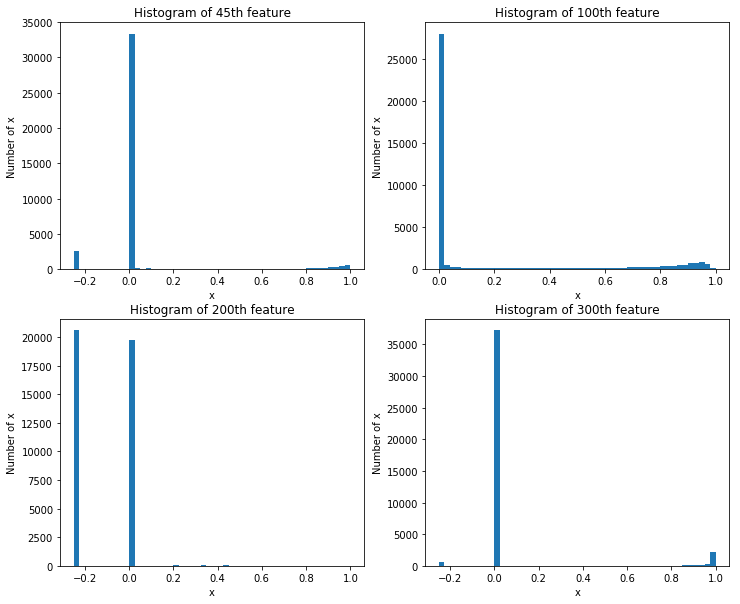

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0,0].hist(X_train[:,45],bins=50)
axs[0,1].hist(X_train[:,100],bins=50)
axs[1,0].hist(X_train[:,200],bins=50)
axs[1,1].hist(X_train[:,300],bins=50)
for ax2 in axs:
    for ax in ax2:
        ax.set_xlabel('x')
        ax.set_ylabel('Number of x')
axs[0,0].set_title('Histogram of 45th feature')
axs[0,1].set_title('Histogram of 100th feature')
axs[1,0].set_title('Histogram of 200th feature')
axs[1,1].set_title('Histogram of 300th feature')
plt.show()

In [14]:
bool_X_train = (X_train==-0.25) | (X_train==0)
fraction = X_train[bool_X_train].shape[0] / (X_train.shape[0]*X_train.shape[1])
print("Fraction of values equal -0.25 and 0 is %f." % fraction)

Fraction of values equal -0.25 and 0 is 0.803624.


In [15]:
aug_fn = lambda X: np.concatenate([X, X==0, X<0], axis=1)
aug_X_train = aug_fn(X_train)
aug_X_val = aug_fn(X_val)
aug_X_test = aug_fn(X_test)
ww_aug,bb_aug = fit_linreg(aug_X_train,y_train,10)

train_rmse_aug = rmse(aug_X_train,y_train,ww_aug,bb_aug)
val_rmse_aug = rmse(aug_X_val,y_val,ww_aug,bb_aug)
test_rmse_aug = rmse(aug_X_test,y_test,ww_aug,bb_aug)
print("train rmse = %f, val rmse = %f, test rmse = %f" % (train_rmse_aug,val_rmse_aug,test_rmse_aug))

train rmse = 0.317842, val rmse = 0.376945, test rmse = 0.430460


Most values hold value of zero. About 80.36% of features hold value of -0.25 or 0. 

| &nbsp;                                         | Train               | Val                 | Test                |
|------------------------------------------------|---------------------|---------------------|---------------------|
| Linear regression (least squares) augment data | $3.18\times10^{-1}$ | $3.77\times10^{-1}$ | $4.30\times10^{-1}$ |

Intuitively, when fitting to more input features, we fits a large model with more parameters to high-dimensional data. A large model has more freedom and can fit closely to data. 

From the histograms and the fact that most features are -0.25 or 0, it is reasonable to treat features as categorical features. We can categorize features by value into 3 categories (i.e. zeros, positves and negatives). aug_fn concatenates original $N\times D$ input matrix with two binary matrix and returns an $N\times3D$ augmented dataset.

Suppose we categorize features into zeros and non-zeros. In a feature vector, zeros are labelled as 1, non-zeros are labelled as 1. A feature vector is then one-hot encoded as a binary feature vector with multiple labels. This gives us a binary input matrix. Similarly, we can categorize features into negatives and non-negatives. 

Consider $N\times D$ X_train is a numerical representation of categorical features, we want to encode a numerical feature vector into a categorial feature vector. We encode a D-dimensional numerical vector to a 2D-dimensional binary vector.

# Q4

In [16]:
def fit_logreg_gradopt(X, yy, alpha):
    D = X.shape[1]
    args = (X, yy, alpha)
    init = (np.zeros(D), np.array(0))
    ww, bb = minimize_list(logreg_cost, init, args)
    return ww, bb


K = 10
wws = np.empty((X_train.shape[1],K)) # weights of 10 classification tasks
bbs = np.empty(K) # biases of 10 classification tasks
mx = np.max(y_train)
mn = np.min(y_train)
hh = (mx-mn)/(K+1)
thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)
for kk in range(K):
    labels = y_train > thresholds[kk]
    wws[:,kk], bbs[kk] = fit_logreg_gradopt(X_train, labels, 10)

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

prob_X_train = np.dot(X_train,wws)+bbs
prob_X_val = np.dot(X_val,wws)+bbs
prob_X_test = np.dot(X_test,wws)+bbs

sigmoid_vec = np.vectorize(sigmoid)
prob_X_train = sigmoid_vec(prob_X_train)
prob_X_val = sigmoid_vec(prob_X_val)
prob_X_test = sigmoid_vec(prob_X_test)

In [18]:
ww_prob,bb_prob = fit_linreg(prob_X_train, y_train, 10)
train_rmse_prob = rmse(prob_X_train, y_train, ww_prob, bb_prob)
val_rmse_prob = rmse(prob_X_val, y_val, ww_prob, bb_prob)
test_rmse_prob = rmse(prob_X_test, y_test, ww_prob, bb_prob)
print("train rmse = %f, val rmse = %f, test rmse = %f" % (train_rmse_prob,val_rmse_prob,test_rmse_prob))

train rmse = 0.138275, val rmse = 0.252189, test rmse = 0.289803


| &nbsp;                       | Train               | Val                 | Test                |
|------------------------------|---------------------|---------------------|---------------------|
| Logistic & linear regression | $1.38\times10^{-1}$ | $2.52\times10^{-1}$ | $2.90\times10^{-1}$ |

PCA projects high-dimensional dataset to low-dimension. PCA changes the diemtnsion to 10 principal components with most variation but drop other components that contributes the least to variation in dataset. principal components with most variation can strongly differ relative locations of CT slices. In other words, these 10 principal components can best reconstruct the original dataset. 

In this question, we reduced D-dimension to 10-dimension by fitting a logistic regression model. Then, we use the ouputs from logistic regression model as inputs to fit a linear regressoin model. Suppose we use gradient optimization fit both linear and logistic models, it is not exactly fitting a neural network because errors of the second linear model does not back propagate throught the first logistic model. Precisely speaking, we fit two regression models, but we kind of reduce dimensionality by a hidden layer of 10 units. 

PCA is faster because PCA gives 10 linear combinations of features that matter the most. Gradient optimization is much slower. However, information that can distinguish results might be stored in low variance components. Therefore, neural networks are likely to have less training errors. 

# Q5

In [19]:
# glorot uniform init
def glorot_uniform_init(shape):
    gain = 1
    std = gain * (2./sum(shape))**0.5
    half_width = 3.**0.5 * std
    return np.random.uniform(low=-half_width, high=half_width, size=shape)

def fit_nn_gradopt(X, yy, alpha):
    """
    ww K,  hidden-output weights
    bb     scalar output bias
    V  K,D hidden-input weights
    bk K,  hidden biases
    """
    K = 10
    D = X.shape[1]
    args = (X, yy, alpha)
    ww = glorot_uniform_init((K,))
    bb = np.array(0)
    V  = glorot_uniform_init((K,D))
    bk = np.zeros(K)
    init = (ww,bb,V,bk)
    ww, bb, V, bk = minimize_list(nn_cost, init, args)
    return ww, bb, V, bk

In [20]:
ww, bb, V, bk = fit_nn_gradopt(X_train, y_train, 10)
params = [ww,bb,V,bk]
train_se_glorot,_ = nn_cost(params, X_train, y_train, 10)
train_rmse_glorot = (train_se_glorot/X_train.shape[0])**0.5
val_se_glorot,_ = nn_cost(params, X_val, y_val, 10)
val_rmse_glorot = (val_se_glorot/X_val.shape[0])**0.5
test_se_glorot,_ = nn_cost(params, X_test, y_test, 10)
test_rmse_glorot = (test_se_glorot/X_test.shape[0])**0.5
print("glorot uniform init train rmse = %f, val rmse = %f, test rmse = %f" % 
      (train_rmse_glorot,val_rmse_glorot,test_rmse_glorot))

glorot uniform init train rmse = 0.162739, val rmse = 0.422775, test rmse = 0.419927


In [21]:
# q4 init
def fit_nn_gradopt_q4(X, yy, alpha):
    """
    ww K,  hidden-output weights
    bb     scalar output bias
    V  K,D hidden-input weights
    bk K,  hidden biases
    """
    args = (X, yy, alpha)
    init = (ww_prob,bb_prob,wws,bbs)
    ww, bb, V, bk = minimize_list(nn_cost, init, args)
    return ww, bb, V, bk

In [22]:
ww, bb, V, bk = fit_nn_gradopt(X_train, y_train, 10)
params = [ww,bb,V,bk]
train_se_q4,_ = nn_cost(params, X_train, y_train, 10)
train_rmse_q4 = (train_se_q4/X_train.shape[0])**0.5
val_se_q4,_ = nn_cost(params, X_val, y_val, 10)
val_rmse_q4 = (val_se_q4/X_val.shape[0])**0.5
test_se_q4,_ = nn_cost(params, X_test, y_test, 10)
test_rmse_q4 = (test_se_q4/X_test.shape[0])**0.5
print("q4 init train rmse = %f, val rmse = %f, test rmse = %f" % 
      (train_rmse_q4,val_rmse_q4,test_rmse_q4))

q4 init train rmse = 0.162871, val rmse = 0.417746, test rmse = 0.420747


| &nbsp;                          | Train               | Val                 | Test                |
|---------------------------------|---------------------|---------------------|---------------------|
| Glorot init NN                  | $1.60\times10^{-1}$ | $4.23\times10^{-1}$ | $4.23\times10^{-1}$ |
| Q4 init NN                      | $1.61\times10^{-1}$ | $4.24\times10^{-1}$ | $4.17\times10^{-1}$ |
| Q4 logistic & linear regression | $1.38\times10^{-1}$ | $2.52\times10^{-1}$ | $2.90\times10^{-1}$ |

Glorot initialization and initialization with parameters in Q4 gave roughly the same errors. Glorot initialization worked slightly better. 

Sigmoid function saturates at tail of 0 and 1. Gradents as tails are colse to zero. During backpropagration, gradient of sigmoid is multiplied to the gradient of cost function with respect to the output of sigmoid function. This leads to hardly any update to parameters, and the learning becomes extremely slow. In order to effectively training the neural network, we need to initialize weights within a range such that derivatives are larger. 

No. Fitting the neural networks does not work better than the procedure in Q4. Though this neural network has the same number of parameters as Q4 model, a neural network is a more powerful model than a combination of two regressoin models. A powerful model is likely to overfit. 

# Q6

| &nbsp;                                         | Train               | Val                 | Test                |
|------------------------------------------------|---------------------|---------------------|---------------------|
| Linear regression (gradient method)            | $3.56\times10^{-1}$ | $4.21\times10^{-1}$ | $4.44\times10^{-1}$ |
| Linear regression (least squares)              | $3.56\times10^{-1}$ | $4.21\times10^{-1}$ | $4.44\times10^{-1}$ |
| Linear regression (least squares) PCA K=10     | $5.73\times10^{-1}$ | $5.72\times10^{-1}$ | $5.54\times10^{-1}$ |
| Linear regression (least squares) PCA K=100    | $4.11\times10^{-1}$ | $4.33\times10^{-1}$ | $4.29\times10^{-1}$ |
| Linear regression (least squares) augment data | $3.18\times10^{-1}$ | $3.77\times10^{-1}$ | $4.30\times10^{-1}$ |
| Q4 logistic & linear regression                | $1.38\times10^{-1}$ | $2.52\times10^{-1}$ | $2.90\times10^{-1}$ |
| Glorot init NN                                 | $1.64\times10^{-1}$ | $4.22\times10^{-1}$ | $4.28\times10^{-1}$ |
| Q4 init NN                                     | $1.65\times10^{-1}$ | $4.39\times10^{-1}$ | $4.28\times10^{-1}$ |


It appears that complex models tend to overfit the data. I tried adjusting the regularization coefficient by grid search alpha between 0 and 2800. It shows that alpha between 500 and 1000 gives smaller test error. I then fine search between 500 and 1000. With alpha set to approximately 800, linear regression by least squares gives the smallest test error $4.28\times 10^{-1}$.

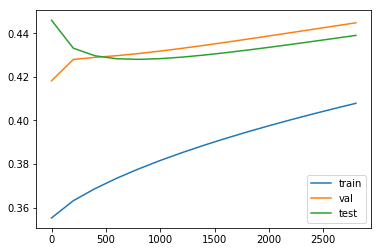

In [23]:
rmse_dict = {
    "train": [],
    "val": [],
    "test": []
}

for alpha in range(0,3000,200):
    ww_lstsq, bb_lstsq = fit_linreg(X_train, y_train, alpha)
    rmse_dict['train'] += [rmse(X_train,y_train,ww_lstsq,bb_lstsq)]
    rmse_dict['val'] += [rmse(X_val,y_val,ww_lstsq,bb_lstsq)]
    rmse_dict['test'] += [rmse(X_test,y_test,ww_lstsq,bb_lstsq)]

for key,value in rmse_dict.items():
    plt.plot(range(0,3000,200),value,label=key)
plt.legend()
plt.show()

In [24]:
for alpha in range(500,1000,50):
    ww_lstsq, bb_lstsq = fit_linreg(X_train, y_train, alpha)
    print("lstsq train with alpha = %d: rmse = %f, val rmse = %f, test rmse = %f" 
          % (alpha, rmse(X_train,y_train,ww_lstsq,bb_lstsq), 
             rmse(X_val,y_val,ww_lstsq,bb_lstsq), 
             rmse(X_test,y_test,ww_lstsq,bb_lstsq)))

lstsq train with alpha = 500: rmse = 0.371153, val rmse = 0.429326, test rmse = 0.428825
lstsq train with alpha = 550: rmse = 0.372324, val rmse = 0.429525, test rmse = 0.428540
lstsq train with alpha = 600: rmse = 0.373462, val rmse = 0.429736, test rmse = 0.428330
lstsq train with alpha = 650: rmse = 0.374569, val rmse = 0.429959, test rmse = 0.428183
lstsq train with alpha = 700: rmse = 0.375647, val rmse = 0.430195, test rmse = 0.428092
lstsq train with alpha = 750: rmse = 0.376698, val rmse = 0.430443, test rmse = 0.428049
lstsq train with alpha = 800: rmse = 0.377725, val rmse = 0.430702, test rmse = 0.428048
lstsq train with alpha = 850: rmse = 0.378728, val rmse = 0.430972, test rmse = 0.428083
lstsq train with alpha = 900: rmse = 0.379710, val rmse = 0.431253, test rmse = 0.428151
lstsq train with alpha = 950: rmse = 0.380671, val rmse = 0.431542, test rmse = 0.428248
